# Introduction

The [Santander Cycle Hire Scheme](https://console.cloud.google.com/marketplace/product/greater-london-authority/london-bicycles) dataset was queried in the [queries.sql](queries.sql) file to obtain the average daily bike change at each station for 2022. This information can be leveraged to plan the manual relocation of these bikes, which is especially important for stations with large net daily influxes or outfluxes. We will develop a predictive and space-sensitive algorithm to organise the manual relocation of the bikes. For simplicity's sake, we will assume:
1. The vans used to move the bikes between stations can only carry 10 bikes at once: assuming relocations involving fewer than 10 bikes aren't cost-effective
2. The relocation of bikes is always done at 12:00 am (after all daily bike trips are completed)
3. The daily bike changes throughout 2023 are equal to the 2022-average daily bike changes
4. The distance between any two stations will be the Euclidean distance between the station coordinates
5. At the start of time, bikes are distributed among the stations in proportion to the total number of docks

Below, we will outline the parameters for bike relocation, in order of decreasing importance:
1. The stations should never become completely full or empty of bikes: stations at higher risk of reaching their full capacity or emptying will be prioritised
2. The distance between stations exchanging bikes should be as small as possible

Check the [Example](#Example) section for a simple case showing how the relocation algorithm works.



In [1]:
import pandas as pd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tabulate import tabulate

In [2]:
flux_station = pd.read_csv('flux-station-2022.csv')

In [3]:
flux_station.head()

,station_name,avg_chg_bicycles
0,"Abbey Orchard Street, Westminster",6.038781
1,"Abbotsbury Road, Holland Park",-1.534626
2,"Aberdeen Place, St. John's Wood",-2.587258
3,"Aberfeldy Street, Poplar",-0.002770
4,"Abingdon Green, Westminster",5.110803


In [4]:
flux_station.avg_chg_bicycles.sum()

# The -0.0027 observed is due to the one 2022/2023 trip we allowed previously [-0.0027 * (365 - 4) = 0.97]

-0.0027700831024901618

In [5]:
station = pd.read_csv('station.csv', usecols = ['name', 'longitude', 'latitude', 'bikes_count', 'docks_count', 'nbEmptyDocks'])
station.head()

,latitude,longitude,name,bikes_count,docks_count,nbEmptyDocks
0,51.498898,-0.100441,"Borough Road, Elephant & Castle",40,41,0
1,51.476149,-0.123258,"Teversham Lane, Stockwell",39,39,0
2,51.521776,-0.068856,"Buxton Street 1, Shoreditch",39,41,1
3,51.539329,-0.074285,"Haggerston Road, Haggerston",36,37,1
4,51.525120,-0.015578,"Devons Road, Bow",37,39,2


In [6]:
station_flux = flux_station.merge(station, left_on='station_name', right_on='name').drop('name', axis=1)
station_flux.head()

,station_name,avg_chg_bicycles,latitude,longitude,bikes_count,docks_count,nbEmptyDocks
0,"Abbey Orchard Street, Westminster",6.038781,51.498126,-0.132102,26,29,2
1,"Abbotsbury Road, Holland Park",-1.534626,51.501391,-0.205991,12,24,12
2,"Aberdeen Place, St. John's Wood",-2.587258,51.524826,-0.176268,3,18,15
3,"Aberfeldy Street, Poplar",-0.002770,51.513548,-0.005659,3,16,13
4,"Abingdon Green, Westminster",5.110803,51.497640,-0.125972,8,20,11


In [7]:
station_flux[station_flux.docks_count - station_flux.bikes_count != station_flux.nbEmptyDocks]

# We can see that 193 stations do not have the expected value for the number of empty docks. Further investigation into this matter might be
#  worthwhile; however, for the sake of simplicity, we will overlook the 'nbEmptyDocks' column and assume the information in 'bikes_count' and 
# 'docks_count' is correct.

,station_name,avg_chg_bicycles,latitude,longitude,bikes_count,docks_count,nbEmptyDocks
0,"Abbey Orchard Street, Westminster",6.038781,51.498126,-0.132102,26,29,2
4,"Abingdon Green, Westminster",5.110803,51.497640,-0.125972,8,20,11
8,"Addison Road, Holland Park",-0.487535,51.504199,-0.210941,4,26,21
9,"Aintree Street, Fulham",-1.252078,51.481021,-0.209973,23,24,0
10,"Albany Street, The Regent's Park",-4.368421,51.528302,-0.144466,17,27,9
...,...,...,...,...,...,...,...
782,"William IV Street, Strand",6.650970,51.509462,-0.124749,9,26,16
784,"Windsor Terrace, Hoxton",-4.445983,51.529154,-0.093422,23,24,0
789,"Wormwood Street, Liverpool Street",0.759003,51.516155,-0.082422,8,16,7
790,"Worship Street, Shoreditch",3.504155,51.521668,-0.079609,9,51,41


In [8]:
station_flux.drop('nbEmptyDocks', axis=1, inplace=True)

In [9]:
station_flux.bikes_count.sum()

# The total bikes figure (10967) is different to the one obtained directly from the BigQuery dataset (23427). This may be due to bike 
# replacements during 2022 or due to the addition of bikes since the original station data was last updated; it may be worth investigating 
# further into this. We will use the bike total calculated from the original station data in our analysis.

10967

In [10]:
bike_total = station_flux.bikes_count.sum()
station_total = station_flux.docks_count.sum()

station_flux.bikes_count = (bike_total / station_total) * station_flux.docks_count

station_flux.head()

,station_name,avg_chg_bicycles,latitude,longitude,bikes_count,docks_count
0,"Abbey Orchard Street, Westminster",6.038781,51.498126,-0.132102,15.116112,29
1,"Abbotsbury Road, Holland Park",-1.534626,51.501391,-0.205991,12.509886,24
2,"Aberdeen Place, St. John's Wood",-2.587258,51.524826,-0.176268,9.382414,18
3,"Aberfeldy Street, Poplar",-0.002770,51.513548,-0.005659,8.339924,16
4,"Abingdon Green, Westminster",5.110803,51.497640,-0.125972,10.424905,20


In [11]:
station_flux['bikes_count / docks_count'] = station_flux.bikes_count / station_flux.docks_count
station_flux.head()

,station_name,avg_chg_bicycles,latitude,longitude,bikes_count,docks_count,bikes_count / docks_count
0,"Abbey Orchard Street, Westminster",6.038781,51.498126,-0.132102,15.116112,29,0.521245
1,"Abbotsbury Road, Holland Park",-1.534626,51.501391,-0.205991,12.509886,24,0.521245
2,"Aberdeen Place, St. John's Wood",-2.587258,51.524826,-0.176268,9.382414,18,0.521245
3,"Aberfeldy Street, Poplar",-0.002770,51.513548,-0.005659,8.339924,16,0.521245
4,"Abingdon Green, Westminster",5.110803,51.497640,-0.125972,10.424905,20,0.521245


In [12]:
station_flux['day'] = 0  # Column indicating the day number of our simulation
station_flux['coordinate'] = list(map(Point, station_flux.longitude, station_flux.latitude))

station_flux.head()

,station_name,avg_chg_bicycles,latitude,longitude,bikes_count,docks_count,bikes_count / docks_count,day,coordinate
0,"Abbey Orchard Street, Westminster",6.038781,51.498126,-0.132102,15.116112,29,0.521245,0,POINT (-0.132102166 51.49812559)
1,"Abbotsbury Road, Holland Park",-1.534626,51.501391,-0.205991,12.509886,24,0.521245,0,POINT (-0.205991 51.501391)
2,"Aberdeen Place, St. John's Wood",-2.587258,51.524826,-0.176268,9.382414,18,0.521245,0,POINT (-0.176268 51.524826)
3,"Aberfeldy Street, Poplar",-0.002770,51.513548,-0.005659,8.339924,16,0.521245,0,POINT (-0.005659 51.513548)
4,"Abingdon Green, Westminster",5.110803,51.497640,-0.125972,10.424905,20,0.521245,0,POINT (-0.12597218 51.49764)


In [13]:
def color_map_color(value, cmap_name='RdBu', vmin=0.25, vmax=0.75):
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    rgb = cmap(norm(value))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = mpl.colors.rgb2hex(rgb)
    return color

plt.rcParams['figure.figsize'] = [20, 10]

In [14]:
def map_station_flux():
    fig, ax = plt.subplots()
    ax.scatter(station_flux.longitude, station_flux.latitude, c='w')

    for i, (bikes, docks, bikes_per_dock) in enumerate(zip(station_flux.bikes_count, station_flux.docks_count, 
                                                           station_flux['bikes_count / docks_count'])):
        ax.annotate(f'{bikes:.0f}/{docks:.0f}', (station_flux.longitude[i], station_flux.latitude[i]), c=color_map_color(bikes_per_dock))

    # for xi, yi, txt in zip(longitude, latitude, flux_station.avg_chg_bicycles):
    #     ax.scatter(xi, yi, marker=f'${txt}$', s=200, edgecolors='black')

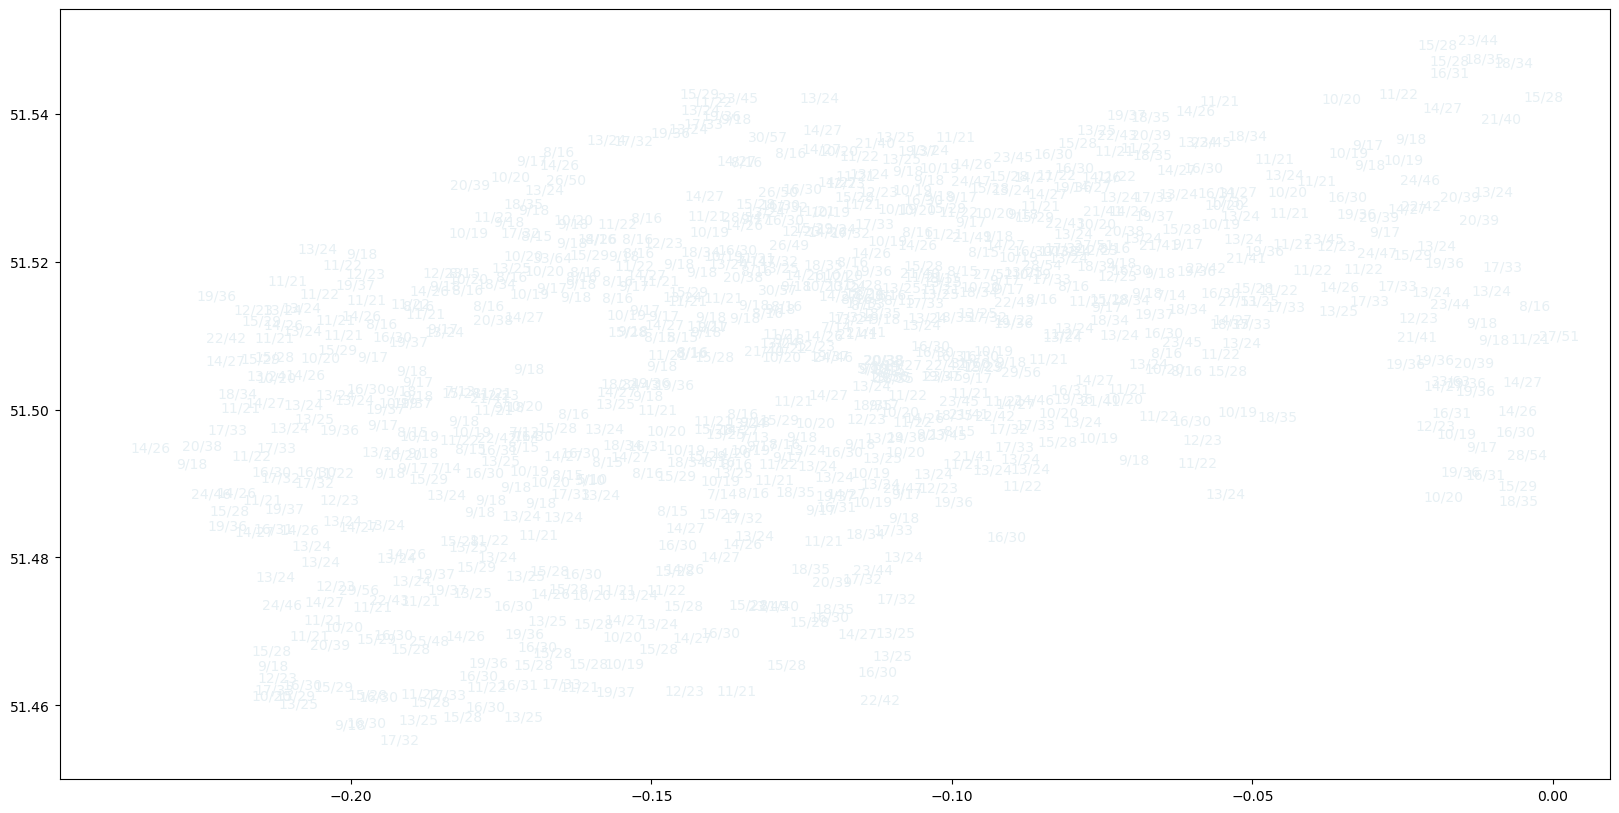

In [15]:
map_station_flux()

# We can see that this represents the 'ideal' scenario for bike distribution, with the stations being half full.

In [16]:
def next_day():
    station_flux.bikes_count = station_flux.bikes_count + station_flux.avg_chg_bicycles
    station_flux['bikes_count / docks_count'] = station_flux.bikes_count / station_flux.docks_count
    station_flux.day += 1

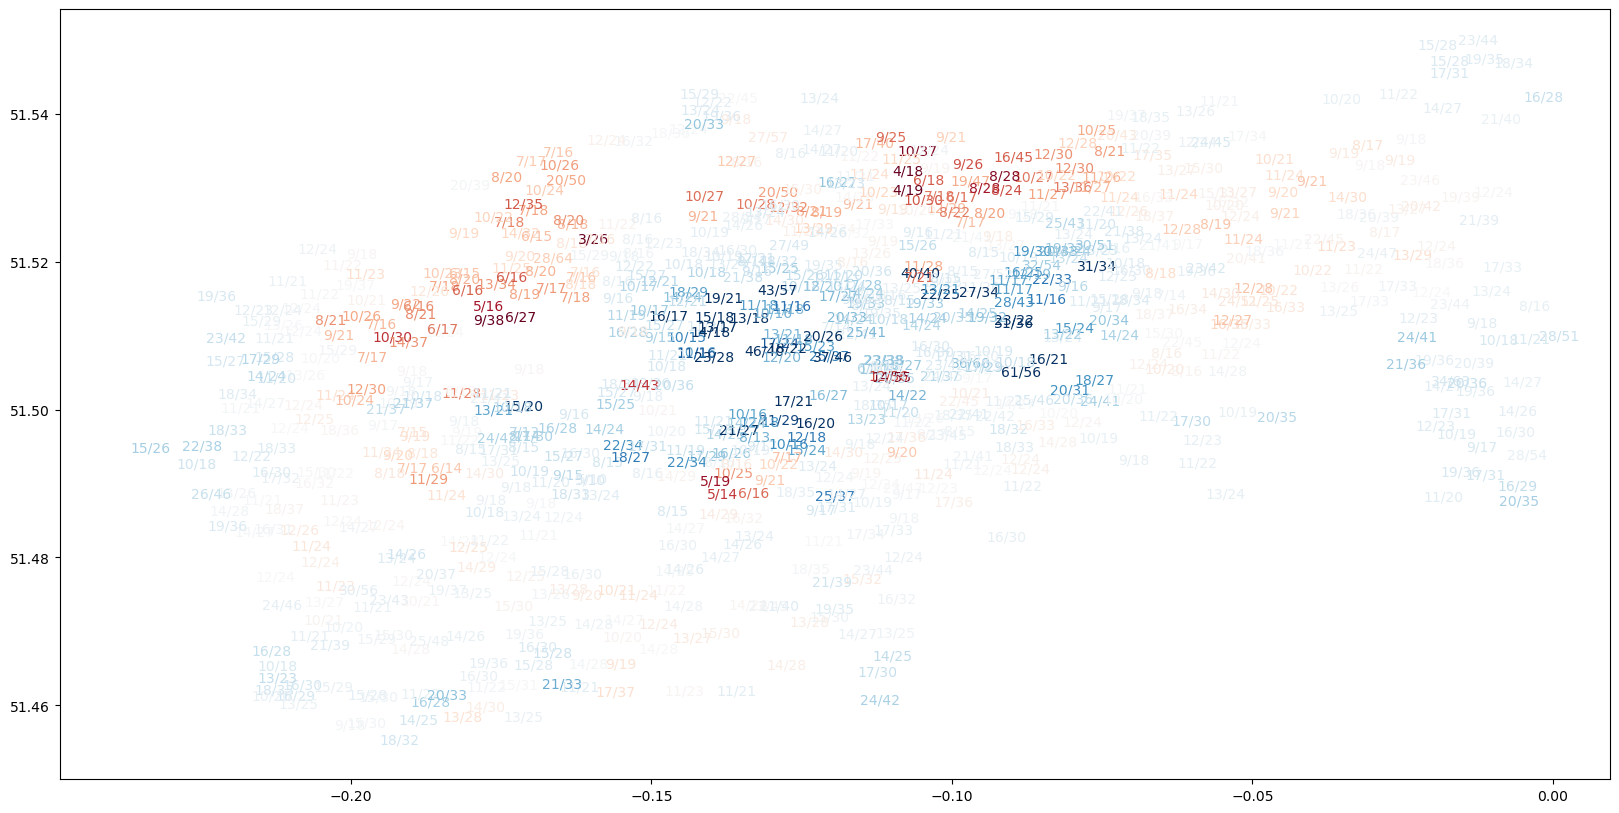

In [17]:
next_day()
map_station_flux()

# After one day, the distribution of bikes changes

In [18]:
def previous_day():
    station_flux.bikes_count = station_flux.bikes_count - station_flux.avg_chg_bicycles
    station_flux['bikes_count / docks_count'] = station_flux.bikes_count / station_flux.docks_count
    station_flux.day -= 1

previous_day()
station_flux.head()

,station_name,avg_chg_bicycles,latitude,longitude,bikes_count,docks_count,bikes_count / docks_count,day,coordinate
0,"Abbey Orchard Street, Westminster",6.038781,51.498126,-0.132102,15.116112,29,0.521245,0,POINT (-0.132102166 51.49812559)
1,"Abbotsbury Road, Holland Park",-1.534626,51.501391,-0.205991,12.509886,24,0.521245,0,POINT (-0.205991 51.501391)
2,"Aberdeen Place, St. John's Wood",-2.587258,51.524826,-0.176268,9.382414,18,0.521245,0,POINT (-0.176268 51.524826)
3,"Aberfeldy Street, Poplar",-0.002770,51.513548,-0.005659,8.339924,16,0.521245,0,POINT (-0.005659 51.513548)
4,"Abingdon Green, Westminster",5.110803,51.497640,-0.125972,10.424905,20,0.521245,0,POINT (-0.12597218 51.49764)


In [19]:
station_flux[(station_flux.bikes_count + station_flux.avg_chg_bicycles > station_flux.docks_count) | 
             (station_flux.bikes_count + station_flux.avg_chg_bicycles < 0)]

# It is necessary to move bikes from these stations to prevent them from reaching full capacity

,station_name,avg_chg_bicycles,latitude,longitude,bikes_count,docks_count,bikes_count / docks_count,day,coordinate
354,"Hop Exchange, The Borough",32.130194,51.504628,-0.091774,29.189734,56,0.521245,0,POINT (-0.091773776 51.50462759)
555,"Queen Street 1, Bank",11.914127,51.511553,-0.092940,11.467395,22,0.521245,0,POINT (-0.0929401 51.51155322)
655,"St. James's Square, St. James's",25.180055,51.507425,-0.134621,20.849810,40,0.521245,0,POINT (-0.134621209 51.50742485)


In [20]:
p1 = station_flux[(station_flux.bikes_count + station_flux.avg_chg_bicycles > station_flux.docks_count)].iloc[0].coordinate

p1_idx = station_flux.index[station_flux.coordinate == p1]
p2_idx = pd.Index([station_flux.loc[(~station_flux.index.isin(p1_idx)) & (station_flux.avg_chg_bicycles < 0) & 
                                    (station_flux.docks_count - station_flux.bikes_count >= 10)
                                    ].coordinate.apply(lambda x: p1.distance(x)).idxmin()])

pd.concat([station_flux.loc[p1_idx], station_flux.loc[p2_idx]])

,station_name,avg_chg_bicycles,latitude,longitude,bikes_count,docks_count,bikes_count / docks_count,day,coordinate
354,"Hop Exchange, The Borough",32.130194,51.504628,-0.091774,29.189734,56,0.521245,0,POINT (-0.091773776 51.50462759)
688,"Swan Street, The Borough",-0.437673,51.500296,-0.092763,14.073622,27,0.521245,0,POINT (-0.092762704 51.50029631)


In [21]:
priority = (station_flux.loc[p1_idx, 'bikes_count'] + station_flux.loc[p1_idx, 'avg_chg_bicycles'] 
            - station_flux.loc[p1_idx, 'docks_count']).values[0]

# Calculating the priority of this bike relocation (based on how much the sum of the bike count and predicted influx exceeds the dock count)

station_flux.loc[p1_idx, 'bikes_count'] = station_flux.loc[p1_idx, 'bikes_count'] - 10
station_flux.loc[p2_idx, 'bikes_count'] = station_flux.loc[p2_idx, 'bikes_count'] + 10

station_flux['bikes_count / docks_count'] = station_flux.bikes_count / station_flux.docks_count

print('Priority: ', priority)
print(tabulate(pd.concat([station_flux.loc[p1_idx], station_flux.loc[p2_idx]]), headers=['station_name', 'avg_chg_bicycles', 'latitude', 'longitude', 'bikes_count', 'docks_count',	'bikes_count /\n docks_count', 'day', 'coordinate'], 
               tablefmt='rounded_grid', maxcolwidths=14))

Priority:  5.319927746121358
╭─────┬────────────────┬────────────────────┬────────────┬─────────────┬───────────────┬───────────────┬─────────────────┬───────┬───────────────╮
│     │ station_name   │   avg_chg_bicycles │   latitude │   longitude │   bikes_count │   docks_count │   bikes_count / │   day │ coordinate    │
│     │                │                    │            │             │               │               │     docks_count │       │               │
├─────┼────────────────┼────────────────────┼────────────┼─────────────┼───────────────┼───────────────┼─────────────────┼───────┼───────────────┤
│ 354 │ Hop Exchange,  │          32.1302   │    51.5046 │  -0.0917738 │       19.1897 │            56 │        0.342674 │     0 │ POINT         │
│     │ The Borough    │                    │            │             │               │               │                 │       │ (-0.091773776 │
│     │                │                    │            │             │               │ 

In [22]:
arrow = pd.DataFrame(columns=['start_station', 'x', 'y', 'dx', 'dy', 'end_station', 'num_bikes', 'priority'])
start_station = station_flux.loc[p1_idx, 'station_name'].values[0]
x = station_flux.loc[p1_idx, 'longitude'].values[0]
y = station_flux.loc[p1_idx, 'latitude'].values[0]
dx = station_flux.loc[p2_idx, 'longitude'].values[0] - x
dy = station_flux.loc[p2_idx, 'latitude'].values[0] - y
end_station = station_flux.loc[p2_idx, 'station_name'].values[0]
num_bikes = 10
arrow.loc[len(arrow)] = [start_station, x, y, dx, dy, end_station, num_bikes, priority]
arrow

,start_station,x,y,dx,dy,end_station,num_bikes,priority
0,"Hop Exchange, The Borough",-0.091774,51.504628,-0.000989,-0.004331,"Swan Street, The Borough",10,5.319928


In [23]:
arrow.loc[len(arrow)] = [start_station, x, y, dx, dy, end_station, 0, 0]
arrow

,start_station,x,y,dx,dy,end_station,num_bikes,priority
0,"Hop Exchange, The Borough",-0.091774,51.504628,-0.000989,-0.004331,"Swan Street, The Borough",10,5.319928
1,"Hop Exchange, The Borough",-0.091774,51.504628,-0.000989,-0.004331,"Swan Street, The Borough",0,0.000000


In [24]:
arrow = arrow.groupby(arrow.columns[:-2].tolist()).sum().reset_index()
arrow

,start_station,x,y,dx,dy,end_station,num_bikes,priority
0,"Hop Exchange, The Borough",-0.091774,51.504628,-0.000989,-0.004331,"Swan Street, The Borough",10,5.319928


In [25]:
arrow.loc[len(arrow)] = [start_station, x, y, -dx, -dy, 'Opposite Direction', 10, 6]
arrow

,start_station,x,y,dx,dy,end_station,num_bikes,priority
0,"Hop Exchange, The Borough",-0.091774,51.504628,-0.000989,-0.004331,"Swan Street, The Borough",10,5.319928
1,"Hop Exchange, The Borough",-0.091774,51.504628,0.000989,0.004331,Opposite Direction,10,6.000000


In [26]:
arrow = arrow.sort_values('priority', ascending=False).reset_index(drop=True)
arrow.index += 1
arrow.head()

,start_station,x,y,dx,dy,end_station,num_bikes,priority
1,"Hop Exchange, The Borough",-0.091774,51.504628,0.000989,0.004331,Opposite Direction,10,6.000000
2,"Hop Exchange, The Borough",-0.091774,51.504628,-0.000989,-0.004331,"Swan Street, The Borough",10,5.319928


In [27]:
def map_move_bike():
    for num_priority, x, y, dx, dy, num_bikes in reversed(list(zip(arrow.index, arrow.x, arrow.y, arrow.dx, arrow.dy, arrow.num_bikes))):
        plt.arrow(x, y, dx, dy, width=1e-6*num_bikes, length_includes_head=True, head_width=1e-4*num_bikes, head_length=5e-5*num_bikes)
        plt.annotate(f'{num_priority}', (x + dx / 2, y + dy / 2), fontsize=7, bbox={"boxstyle" : "circle", "color":"grey"})

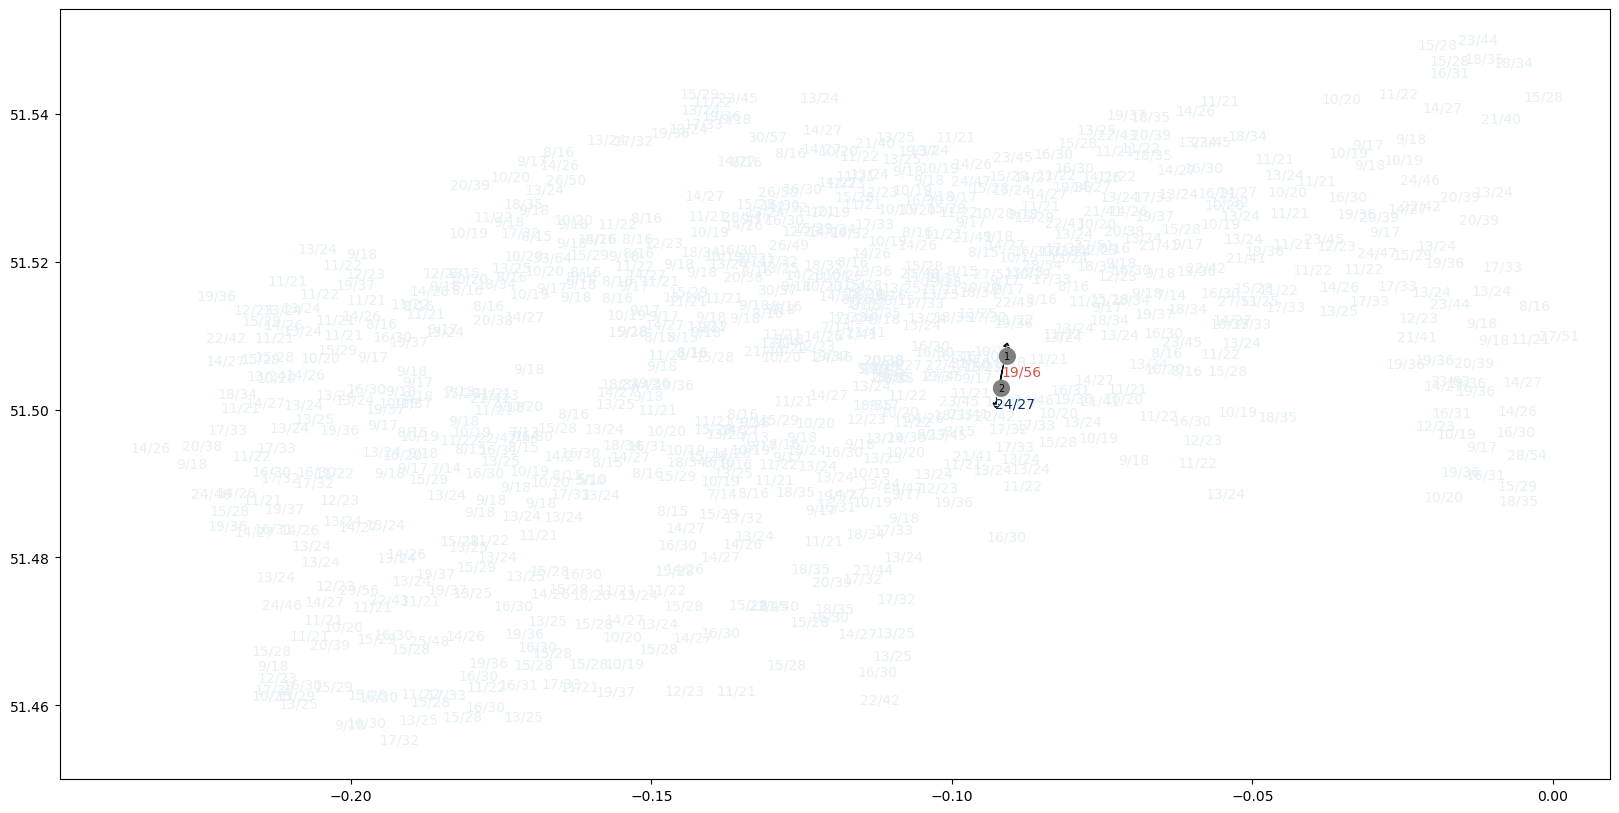

In [28]:
map_station_flux()
map_move_bike()

In [29]:
((station_flux.bikes_count + station_flux.avg_chg_bicycles > station_flux.docks_count) | 
 (station_flux.bikes_count + station_flux.avg_chg_bicycles < 0)).any()

True

╭─────┬────────────────┬────────────────────┬────────────┬─────────────┬───────────────┬───────────────┬─────────────────┬───────┬────────────────╮
│     │ station_name   │   avg_chg_bicycles │   latitude │   longitude │   bikes_count │   docks_count │   bikes_count / │   day │ coordinate     │
│     │                │                    │            │             │               │               │     docks_count │       │                │
├─────┼────────────────┼────────────────────┼────────────┼─────────────┼───────────────┼───────────────┼─────────────────┼───────┼────────────────┤
│ 555 │ Queen Street   │           11.9141  │    51.5116 │  -0.0929401 │       11.4674 │            22 │        0.521245 │     0 │ POINT          │
│     │ 1, Bank        │                    │            │             │               │               │                 │       │ (-0.0929401    │
│     │                │                    │            │             │               │               │        

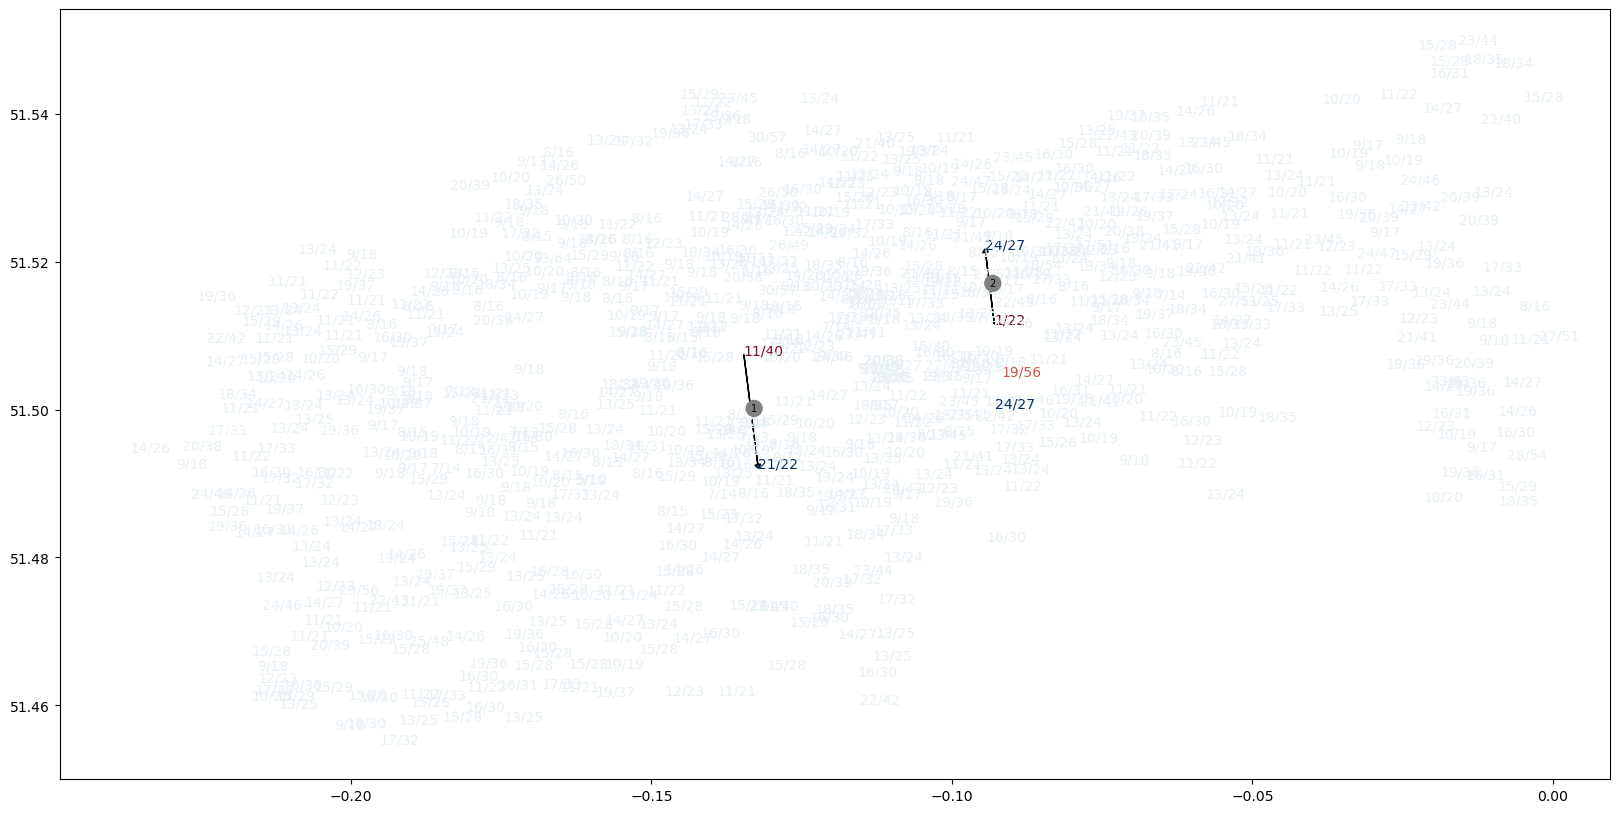

In [30]:
def move_bikes(verbose=True):
    
    arrow = pd.DataFrame(columns=['start_station', 'x', 'y', 'dx', 'dy', 'end_station', 'num_bikes', 'priority'])

    while ((station_flux.bikes_count + station_flux.avg_chg_bicycles > station_flux.docks_count) | (station_flux.bikes_count + station_flux.avg_chg_bicycles < 0)).any():
        
        for p1 in station_flux[(station_flux.bikes_count + station_flux.avg_chg_bicycles < 0)].coordinate:
            p1_idx = station_flux.index[station_flux.coordinate == p1]
            p2_idx = pd.Index([station_flux.loc[(~station_flux.index.isin(p1_idx)) & (station_flux.avg_chg_bicycles > 0) & (station_flux.bikes_count >= 10)].coordinate.apply(lambda x: p1.distance(x)).idxmin()])

            if verbose:
                print(tabulate(pd.concat([station_flux.loc[p1_idx], station_flux.loc[p2_idx]]), headers=['station_name', 'avg_chg_bicycles', 'latitude', 'longitude', 'bikes_count', 'docks_count',	'bikes_count /\n docks_count', 'day', 'coordinate'], 
                               tablefmt='rounded_grid', maxcolwidths=14))

            priority = -1 * (station_flux.loc[p1_idx, 'bikes_count'] + station_flux.loc[p1_idx, 'avg_chg_bicycles']).values[0]

            station_flux.loc[p1_idx, 'bikes_count'] = station_flux.loc[p1_idx, 'bikes_count'] + 10
            station_flux.loc[p2_idx, 'bikes_count'] = station_flux.loc[p2_idx, 'bikes_count'] - 10

            station_flux['bikes_count / docks_count'] = station_flux.bikes_count / station_flux.docks_count

            if verbose:
                print(tabulate(pd.concat([station_flux.loc[p1_idx], station_flux.loc[p2_idx]]), headers=['station_name', 'avg_chg_bicycles', 'latitude', 'longitude', 'bikes_count', 'docks_count',	'bikes_count /\n docks_count', 'day', 'coordinate'], 
                               tablefmt='rounded_grid', maxcolwidths=14))
            
            start_station = station_flux.loc[p2_idx, 'station_name'].values[0]
            x = station_flux.loc[p2_idx, 'longitude'].values[0]
            y = station_flux.loc[p2_idx, 'latitude'].values[0]
            dx = station_flux.loc[p1_idx, 'longitude'].values[0] - x
            dy = station_flux.loc[p1_idx, 'latitude'].values[0] - y
            end_station = station_flux.loc[p1_idx, 'station_name'].values[0]
            num_bikes = 10
            arrow.loc[len(arrow)] = [start_station, x, y, dx, dy, end_station, num_bikes, priority]

        for p1 in station_flux[(station_flux.bikes_count + station_flux.avg_chg_bicycles > station_flux.docks_count)].coordinate:
            p1_idx = station_flux.index[station_flux.coordinate == p1]
            p2_idx = pd.Index([station_flux.loc[(~station_flux.index.isin(p1_idx)) & (station_flux.avg_chg_bicycles < 0) & (station_flux.docks_count - station_flux.bikes_count >= 10)].coordinate.apply(lambda x: p1.distance(x)).idxmin()])

            if verbose:
                print(tabulate(pd.concat([station_flux.loc[p1_idx], station_flux.loc[p2_idx]]), headers=['station_name', 'avg_chg_bicycles', 'latitude', 'longitude', 'bikes_count', 'docks_count',	'bikes_count /\n docks_count', 'day', 'coordinate'], 
                               tablefmt='rounded_grid', maxcolwidths=14))
                
            priority = (station_flux.loc[p1_idx, 'bikes_count'] + station_flux.loc[p1_idx, 'avg_chg_bicycles'] - station_flux.loc[p1_idx, 'docks_count']).values[0]

            station_flux.loc[p1_idx, 'bikes_count'] = station_flux.loc[p1_idx, 'bikes_count'] - 10
            station_flux.loc[p2_idx, 'bikes_count'] = station_flux.loc[p2_idx, 'bikes_count'] + 10

            station_flux['bikes_count / docks_count'] = station_flux.bikes_count / station_flux.docks_count

            if verbose:
                print(tabulate(pd.concat([station_flux.loc[p1_idx], station_flux.loc[p2_idx]]), headers=['station_name', 'avg_chg_bicycles', 'latitude', 'longitude', 'bikes_count', 'docks_count',	'bikes_count /\n docks_count', 'day', 'coordinate'], 
                               tablefmt='rounded_grid', maxcolwidths=14))
                
            start_station = station_flux.loc[p1_idx, 'station_name'].values[0]
            x = station_flux.loc[p1_idx, 'longitude'].values[0]
            y = station_flux.loc[p1_idx, 'latitude'].values[0]
            dx = station_flux.loc[p2_idx, 'longitude'].values[0] - x
            dy = station_flux.loc[p2_idx, 'latitude'].values[0] - y
            end_station = station_flux.loc[p2_idx, 'station_name'].values[0]
            num_bikes = 10
            arrow.loc[len(arrow)] = [start_station, x, y, dx, dy, end_station, num_bikes, priority]

    arrow = arrow.groupby(arrow.columns[:-2].tolist()).sum().reset_index()
    arrow = arrow.sort_values('priority', ascending=False).reset_index(drop=True)
    arrow.index += 1

    return arrow

arrow = move_bikes()
map_station_flux()
map_move_bike()

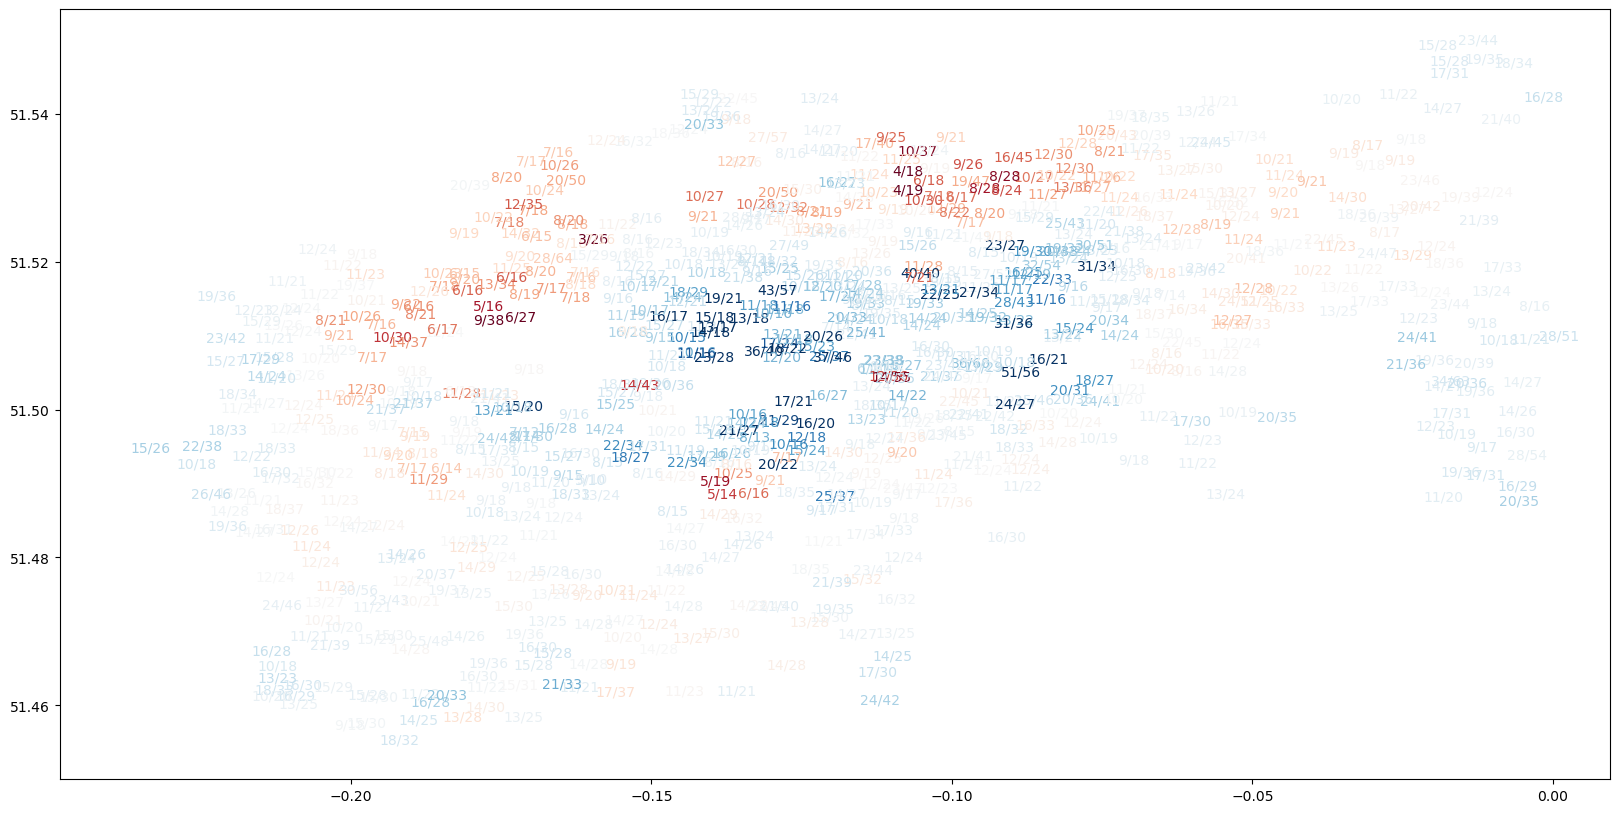

In [31]:
next_day()
map_station_flux()

╭─────┬────────────────┬────────────────────┬────────────┬─────────────┬───────────────┬───────────────┬─────────────────┬───────┬────────────────╮
│     │ station_name   │   avg_chg_bicycles │   latitude │   longitude │   bikes_count │   docks_count │   bikes_count / │   day │ coordinate     │
│     │                │                    │            │             │               │               │     docks_count │       │                │
├─────┼────────────────┼────────────────────┼────────────┼─────────────┼───────────────┼───────────────┼─────────────────┼───────┼────────────────┤
│  51 │ Bayswater      │          -8.15789  │    51.5119 │   -0.174411 │       5.91573 │            27 │        0.219101 │     1 │ POINT          │
│     │ Road, Hyde     │                    │            │             │               │               │                 │       │ (-0.174411     │
│     │ Park           │                    │            │             │               │               │        

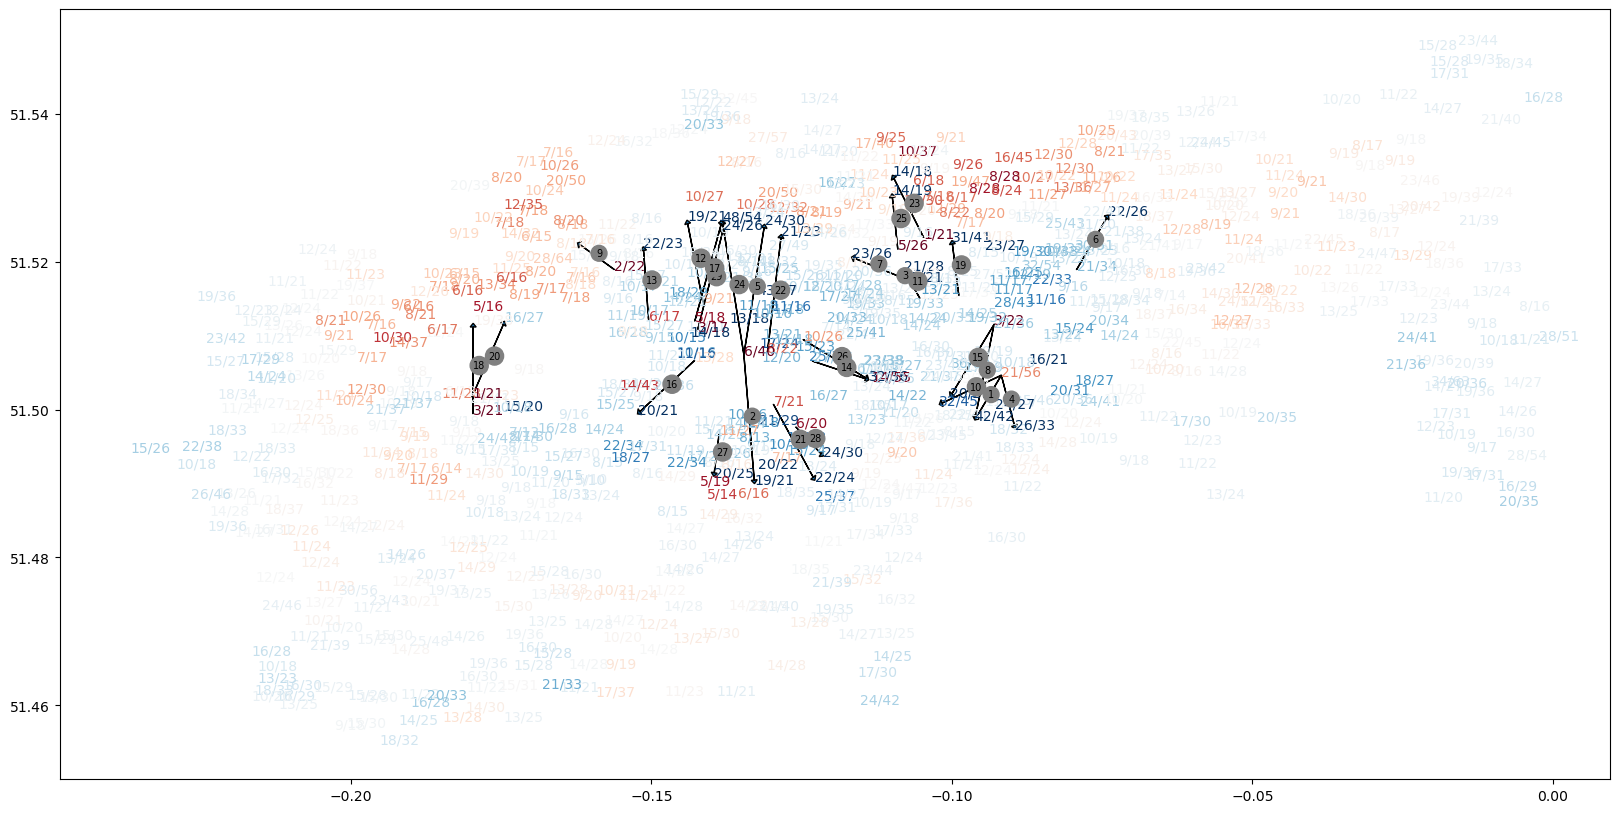

In [32]:
arrow = move_bikes()
map_station_flux()
map_move_bike()

In [33]:
arrow

,start_station,x,y,dx,dy,end_station,num_bikes,priority
1,"Hop Exchange, The Borough",-0.091774,51.504628,-0.004417,-0.006030,"Harper Road, The Borough",10,27.450122
2,"St. James's Square, St. James's",-0.134621,51.507425,0.001776,-0.017449,"Rampayne Street, Pimlico",10,21.209921
3,"Holborn Circus, Holborn",-0.108657,51.517950,0.000670,-0.000522,"New Fetter Lane, Holborn",10,18.777788
4,"Hop Exchange, The Borough",-0.091774,51.504628,0.002327,-0.007245,"Great Dover Street, The Borough",10,17.450122
5,"St. James's Square, St. James's",-0.134621,51.507425,0.003460,0.017626,"Taviton Street, Bloomsbury",10,11.209921
6,"Brushfield Street, Liverpool Street",-0.079249,51.518908,0.005294,0.007385,"Palissy Street, Shoreditch",10,9.589374
7,"Holborn Circus, Holborn",-0.108657,51.517950,-0.008031,0.002647,"Theobald's Road , Holborn",10,8.777788
8,"Queen Street 2, Bank",-0.093051,51.511246,-0.003140,-0.012648,"Harper Road, The Borough",10,7.895023
9,"Baker Street, Marylebone",-0.156167,51.518913,-0.006131,0.003598,"Boston Place, Marylebone",10,7.677540
10,"Hop Exchange, The Borough",-0.091774,51.504628,-0.010317,-0.003934,"Webber Street , Southwark",10,7.450122


# Example

In [34]:
station_flux.drop(station_flux.index, inplace=True)
station_flux.head()

,station_name,avg_chg_bicycles,latitude,longitude,bikes_count,docks_count,bikes_count / docks_count,day,coordinate


In [35]:
station_flux.loc[0] = ['A', -13, 0, 0, 10, 20, 10/20, 0, Point(0, 0)]
station_flux.loc[1] = ['B', +13, 0, 0.04, 13, 25, 13/25, 0, Point(0, 4)]
station_flux.loc[2] = ['C', +5, 0.02, 0, 15, 30, 15/30, 0, Point(2, 0)]
station_flux.loc[3] = ['D', -5, 0.02, 0.04, 18, 35, 18/35, 0, Point(2, 4)]

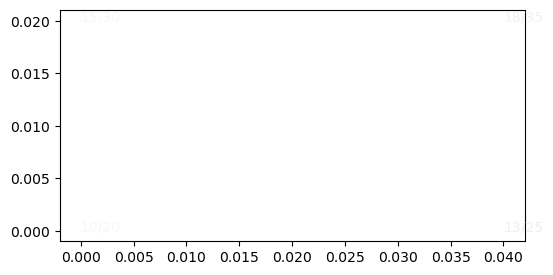

In [36]:
plt.rcParams['figure.figsize'] = [6, 3]

map_station_flux()

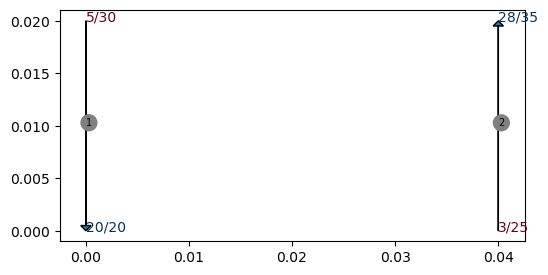

In [37]:
arrow = move_bikes(False)
map_station_flux()
map_move_bike()

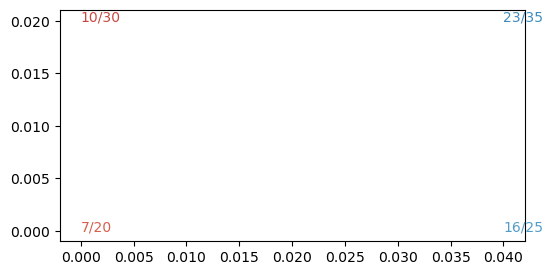

In [38]:
next_day()
map_station_flux()

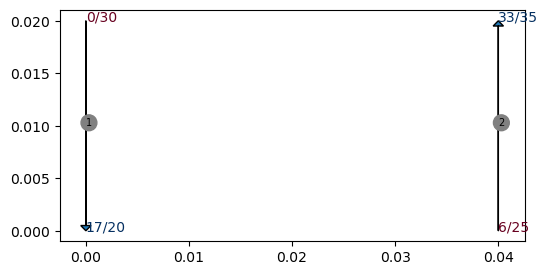

In [39]:
arrow = move_bikes(False)
map_station_flux()
map_move_bike()

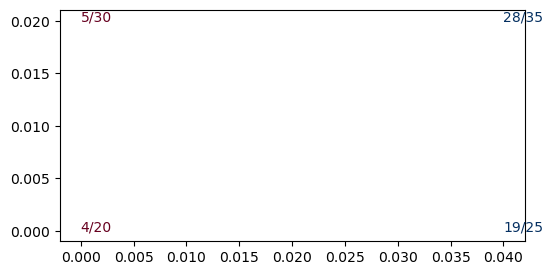

In [40]:
next_day()
map_station_flux()

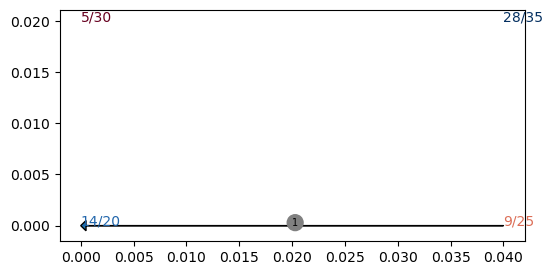

In [41]:
arrow = move_bikes(False)
map_station_flux()
map_move_bike()